# PROOF OF CONCEPT

In [25]:
import os
import numpy as np
import cv2
import shutil
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from rembg import remove
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet_v2, inception_v3, inception_resnet_v2, efficientnet_v2
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [26]:
## GLOBAL VARIRABLES
input_shape = (224,224)
channels = 3
epochs = 256
batch_size = 4
preprocessing_function=efficientnet_v2.preprocess_input

## Path Declerations
dataPath = "pngData"
noBgDataPath="noBgData"
classes = os.listdir(dataPath)

## PREPROCESSING

In [3]:
## REMOVING BACKGROUND AND RETAINING SOIL
## RESIZING IMAGES FROM 416x416 to 224x224
## src: https://www.geeksforgeeks.org/how-to-remove-the-background-from-an-image-using-python/
  

# CHECKS IF DATA DIRECTORIES EXISTS
# DELETE IF SO, CREATE OTHERWISE
for c in classes:
    classPath = os.path.join(noBgDataPath,c)
    if os.path.exists(classPath): shutil.rmtree(classPath); os.mkdir(classPath)
    else: os.mkdir(classPath)

for c in classes:
    classPath = os.path.join(dataPath,c)
    images = os.listdir(classPath)
    for image in images:
        imagePath = os.path.join(classPath,image)
  
        ## RESIZING IMAGE
        origImage = cv2.imread(imagePath)
        resizedImage = cv2.resize(origImage, input_shape, interpolation = cv2.INTER_NEAREST)
        cv2.imwrite(imagePath,resizedImage)

        # Processing the image
        input = Image.open(imagePath)
        
        # Removing the background from the given Image
        output = remove(input)
        
        #Saving the image in the given path
        output_path = imagePath.replace(dataPath,noBgDataPath)
        output.save(output_path)

In [4]:
## Showing Sample Images WITH BG
rawImagePath = "pngData\9\9P--2-_png.rf.86bd5fc1ea384155983df7316c11eea3.png"
rawImage = cv2.imread(rawImagePath)
for i in rawImage: 
    print(i)


[[174 180 185]
 [180 186 191]
 [176 183 186]
 [164 169 172]
 [184 189 190]
 [181 185 186]
 [184 186 186]
 [186 188 188]
 [187 189 189]
 [187 190 188]
 [186 190 185]
 [188 192 187]
 [190 194 189]
 [189 193 188]
 [194 198 193]
 [197 201 196]
 [178 182 177]
 [174 178 173]
 [117 123 122]
 [ 37  46  50]
 [ 45  57  67]
 [ 61  74  88]
 [ 85  96 110]
 [131 138 147]
 [181 180 182]
 [212 207 204]
 [210 206 205]
 [210 208 207]
 [211 209 208]
 [211 209 208]
 [210 208 207]
 [211 209 208]
 [213 211 210]
 [214 212 211]
 [216 214 213]
 [216 213 209]
 [216 213 209]
 [217 214 210]
 [218 215 211]
 [219 216 212]
 [218 215 211]
 [218 215 211]
 [217 214 210]
 [217 214 210]
 [224 220 215]
 [223 219 214]
 [223 219 214]
 [223 219 214]
 [223 219 214]
 [225 221 216]
 [225 221 216]
 [225 221 216]
 [225 222 217]
 [225 222 217]
 [226 223 218]
 [227 224 219]
 [227 224 219]
 [227 224 219]
 [229 226 221]
 [230 227 222]
 [231 228 223]
 [230 227 222]
 [230 227 222]
 [230 227 222]
 [230 227 222]
 [230 227 222]
 [230 227 

In [5]:
## Showing Sample Images NO BG
processedImagePath = "noBgData\9\9P--2-_png.rf.86bd5fc1ea384155983df7316c11eea3.png"
processedImage = cv2.imread(processedImagePath)
for i in processedImage: 
    print(i)


[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 

In [6]:
processedImage.shape

(224, 224, 3)

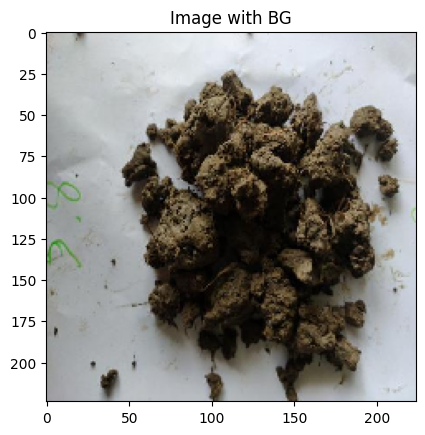

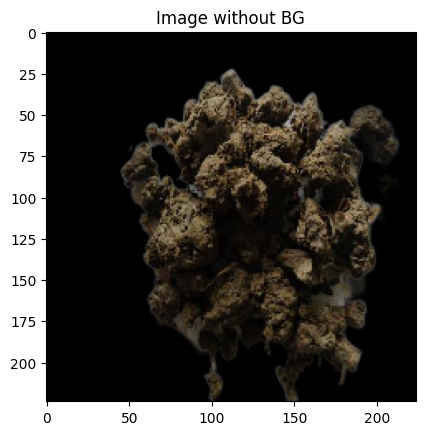

In [7]:
## Showing Sample Images

colorRawImage = cv2.cvtColor(rawImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorRawImage)
plt.title('Image with BG')
plt.show()

colorProcessedImage = cv2.cvtColor(processedImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorProcessedImage)
plt.title('Image without BG')
plt.show()

In [8]:
path = "data"
train = 0.80
val = 1. - train
trainPath = os.path.join(path,"train")
valPath = os.path.join(path,"val")
PATHS = [trainPath, valPath]

# ## CHECKING IF TRAIN AND VAL PATHS EXISTS
# ## IF SO, DELETE, IF NOT THEN CREATE
# for path in PATHS:
#     pass
#     if os.path.exists(path): 
#         shutil.rmtree(path)
#         os.mkdir(path)
#         for c in classes:
#             classPath = os.path.join(path,c)
#             os.mkdir(classPath)
#     else: 
#         os.mkdir(path)
#         for c in classes:
#             classPath = os.path.join(path,c)
#             os.mkdir(classPath)

# ## SEPARATING TO TRAIN AND VALIDATION SETS
# for c in classes:
#     classPath = os.path.join(noBgDataPath,c)
#     images = os.listdir(classPath)
#     numImages = len(images)
#     setClassPath = os.path.join(trainPath,c)
#     for n,image in enumerate(images):
#         if n == round(numImages*train): 
#             setClassPath = os.path.join(valPath,c)
#         imagePath = os.path.join(classPath,image)
#         newImagePath = os.path.join(setClassPath,image)
#         shutil.copy(imagePath, newImagePath)

In [9]:
print("Train Images per Class", len(os.listdir('data//train//7')))
print("Validation Images per Class", len(os.listdir('data//val//7')))

Train Images per Class 64
Validation Images per Class 16


In [10]:
trainGenerator = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    width_shift_range=0.4,
                                    height_shift_range=0.4,
                                    rotation_range=45,
                                    preprocessing_function=preprocessing_function,
                                    ).flow_from_directory(
                                            directory=trainPath,
                                            target_size=input_shape,
                                            class_mode='categorical',
                                            batch_size=batch_size
                                        )

valGenerator = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocessing_function,
                                  ).flow_from_directory(
                                        directory=valPath,
                                        target_size=input_shape,
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

Found 256 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


 ## MODEL TRAINING

In [11]:
tf_model = efficientnet_v2.EfficientNetV2L(include_top=False,
                            weights="imagenet",
                            input_shape= input_shape+(channels,)
                            )

In [12]:

model = Sequential()
model.add(tf_model)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dropout(0.5))

# model.add(layers.BatchNormalization())
# model.add(layers.Dense(units=2048, kernel_regularizer=L2()))
# model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=256, kernel_regularizer=L2()))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [13]:
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(1e-4),
                metrics=['acc']
                )

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=6, min_lr=1e-7)
es = EarlyStopping(monitor='loss', patience=17)

history = model.fit(trainGenerator, validation_data = valGenerator, 
                        epochs = epochs, callbacks=[reduce_lr, es], 
                        verbose = 1)

Epoch 1/256
64/64 [==============================] - 31s 251ms/step - loss: 7.3820 - acc: 0.2969 - val_loss: 6.3139 - val_acc: 0.2500 - lr: 1.0000e-04
Epoch 2/256
64/64 [==============================] - 14s 220ms/step - loss: 4.5040 - acc: 0.2461 - val_loss: 4.2030 - val_acc: 0.2500 - lr: 1.0000e-04
Epoch 3/256
64/64 [==============================] - 14s 221ms/step - loss: 4.1784 - acc: 0.3086 - val_loss: 3.9232 - val_acc: 0.2500 - lr: 1.0000e-04
Epoch 4/256
64/64 [==============================] - 14s 221ms/step - loss: 3.9552 - acc: 0.3984 - val_loss: 3.8858 - val_acc: 0.2812 - lr: 1.0000e-04
Epoch 5/256
64/64 [==============================] - 14s 221ms/step - loss: 3.8255 - acc: 0.4219 - val_loss: 3.7632 - val_acc: 0.3750 - lr: 1.0000e-04
Epoch 6/256
64/64 [==============================] - 14s 221ms/step - loss: 3.7215 - acc: 0.4414 - val_loss: 3.7323 - val_acc: 0.2344 - lr: 1.0000e-04
Epoch 7/256
64/64 [==============================] - 14s 221ms/step - loss: 3.7320 - acc: 0.36

### TRAINING RESULTS


In [15]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

print("Final Train Loss: {:.4f}".format(train_loss[-1]))
print("Final Validation Loss: {:.4f}".format(val_loss[-1]))
print("Final Test Accuracy: {:.4f}".format(train_acc[-1]))
print("Final Test Accuracy: {:.4f}".format(val_acc[-1]))

Final Train Loss: 2.2618
Final Validation Loss: 3.1661
Final Test Accuracy: 0.5898
Final Test Accuracy: 0.3125


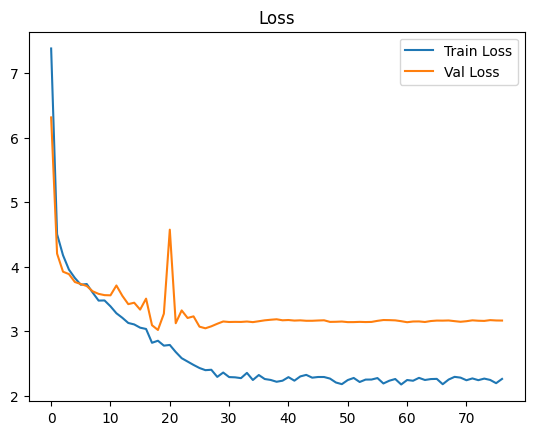

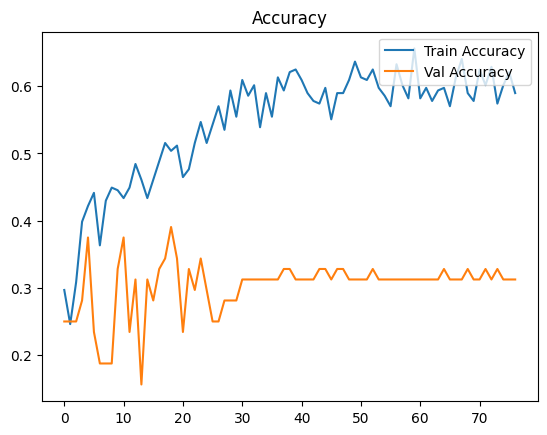

In [16]:

plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Loss")
plt.legend(["Train Loss", "Val Loss"], loc="upper right")
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Accuracy")
plt.legend(["Train Accuracy", "Val Accuracy"], loc="upper right")
plt.show()


(1, 150, 150, 3)


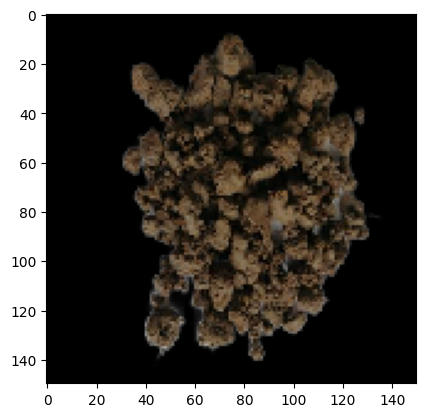

In [18]:
# Pre-processing the image
img_path= "noBgData//6//43--10-_png.rf.515324d7c28acb83c837f6b6ebcf68f7.png"

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.
  
# Print image tensor shape
print(img_tensor.shape)
  
# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [ ]:


# # Outputs of the 8 layers, which include conv2D and max pooling layers
# layer_outputs = [layer.output for layer in model.layers[:8]]
# activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
# activations = activation_model.predict(img_tensor)
  
# # Getting Activations of first layer
# first_layer_activation = activations[0]
  
# # shape of first layer activation
# print(first_layer_activation.shape)
  
# # 6th channel of the image after first layer of convolution is applied
# plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis')
  
# # 15th channel of the image after first layer of convolution is applied
# plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

## MODEL TESTING

## SAVING